# analyze 30 s data sets

### Condensed version of things for Jullian

In [1]:
%matplotlib inline
import os
#import computeDEL
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import scipy.io as spio
#import wrapFunctions #import wrap180, wrap360, wrapList
import glob
import pandas as pd
#from ggplot import *
from scipy import stats

## Parameters

In [2]:
dataFolder = 'data30'
dataFile  = os.path.join(dataFolder,'dataFile.csv')

lowTurb = False # Limit by TI?
tiLim = 6. # % TI to limit to 

## Load the data file

In [3]:
df = pd.read_csv(dataFile)

## Analysis

In [4]:
# Add a channel which is cut wind speed and direction
binEdge = np.arange(3.,20.)
binEdge = np.arange(3.,16.)
df['windRange'] = pd.cut(df.WS1_90m_mean,binEdge,right=True)

binEdge = np.arange(-45.,55.,5) - 2.5
binLabel = range(-45,50,5)
#df['dirBin'] = pd.cut(df.apparantVane_mean,binEdge,right=True,labels=binLabel)
df['dirBin'] = pd.cut(df.WD_Nacelle_mean - 180.,binEdge,right=True,labels=binLabel)

In [5]:
# Limit by TI if told to:
if lowTurb:
    df['TI'] = 100. * df.WS1_90m_std / df.WS1_90m_mean
    df = df[df.TI < tiLim]
    df = df.drop('TI',axis=1)

In [6]:
# Limit to regions with low nacelle error for first plot, which compares the measurement
# between turbine and met mast
dfTemp = df[ abs(df.WD_Nacelle_mean - 180.) < 5.]
dfTemp = dfTemp[ dfTemp.ApparentPower_mean > 150.] # Make sure some power being produced
dfTemp.shape

(11710, 132)

/Users/jquick/myenv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


cauchy (-0.5021542267864816, 3.005080296164434)
t (3.7695485671609057, -0.24433438898097598, 4.334646765128653)
laplace (-2.0594355022850842e-17, 4.411649063578752)


/Users/jquick/myenv/lib/python3.6/site-packages/scipy-1.2.0-py3.6-macosx-10.11-x86_64.egg/scipy/stats/_continuous_distns.py:514: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/jquick/myenv/lib/python3.6/site-packages/scipy-1.2.0-py3.6-macosx-10.11-x86_64.egg/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


beta (2981.6004805186203, 44913.81202790687, -345.480737310068, 5549.684695511145)
norm (-2.0270453369281632e-17, 6.12844458875185)
6.12844458875185


/Users/jquick/myenv/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


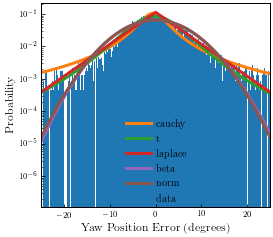

In [7]:
dfTemp['turbinePos'] = dfTemp.Yaw_Encoder_mean + (df.WD_Nacelle_mean - 180.)
fig, ax = plt.subplots(figsize=(4, 3.5))
unclearnerrs = dfTemp.WD1_87m_mean-dfTemp.turbinePos
yawerrs = unclearnerrs[~(np.abs(unclearnerrs)>30)]

SIZE = 12

# subtract mean
yawerrs -= np.mean(yawerrs)

ax.hist(yawerrs, bins=300, normed=1, label='data')
x = np.arange(-30, 30, .01)

distrNameList = ['cauchy', 't', 'laplace', 'beta', 'norm']
for distrName in distrNameList:
    distr = getattr(stats.distributions, distrName)
    param = distr.fit(yawerrs)
    pdf = distr.pdf(x, *param)
    print(distrName, param)
    ax.plot(x, pdf, lw=3, label=distrName)

ax.set_xlim([-25,25])
# ax.axvline(yawerrs.mean(), lw=2, c='k')
ax.set_xlabel("Yaw Position Error" r" (degrees)", size=SIZE)
ax.set_ylabel("Probability", size=SIZE)
ax.set_yscale('log')
plt.legend(prop={'size':SIZE - 2})
print (np.std(yawerrs))
plt.savefig('yawErrorFits.png', dpi=600)

In [8]:
import numpy as np
from floris.floris import Floris
from copy import deepcopy
from floris.visualization import VisualizationManager
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

cauchy (-0.5021542267864816, 3.005080296164434)
t (3.7695485671609057, -0.24433438898097598, 4.334646765128653)
laplace (-2.0594355022850842e-17, 4.411649063578752)
beta (2981.6004805186203, 44913.81202790687, -345.480737310068, 5549.684695511145)
norm (-2.0270453369281632e-17, 6.12844458875185)
6.12844458875185


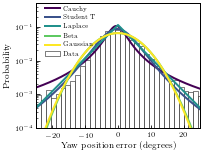

In [16]:
dfTemp['turbinePos'] = dfTemp.Yaw_Encoder_mean + (df.WD_Nacelle_mean - 180.)
fig, ax = plt.subplots(figsize=(3, 2.3))
# plt.subplots_adjust(wspace=3.5)

unclearnerrs = dfTemp.WD1_87m_mean-dfTemp.turbinePos
yawerrs = unclearnerrs[~(np.abs(unclearnerrs)>30)]

SIZE = 9

font = {'size'   : SIZE}
matplotlib.rc('font', **font)

# subtract mean
yawerrs -= np.mean(yawerrs)

ax.hist(yawerrs, bins=40, normed=1, label='Data', facecolor='white', edgecolor='k')
x = np.arange(-30, 30, .01)

distrNameList = ['cauchy', 't', 'laplace', 'beta', 'norm']
namestoprint = {'cauchy':'Cauchy', 't':'Student T', 'laplace': 'Laplace', 'beta':'Beta', 'norm':"Gaussian",'gamma':'Gamma'}
colors = plt.cm.viridis(np.linspace(0, 1, len(distrNameList)))
for ii, distrName in enumerate(distrNameList):
    distr = getattr(stats.distributions, distrName)
    param = distr.fit(yawerrs)
    pdf = distr.pdf(x, *param)
    print(distrName, param)
    ax.plot(x, pdf, lw=2, label=namestoprint[distrName], c=colors[ii])

ax.set_xlim([-25,25])
#ax.set_xlim([-30, 30])
# ax.axvline(yawerrs.mean(), lw=2, c='k')
ax.set_xlabel("Yaw position error" r" (degrees)", size=SIZE)
ax.set_ylabel("Probability", size=SIZE)
ax.set_yscale('log')
ax.set_ylim(1e-4, 5e-1)
ax.legend(prop={'size':SIZE - 3}, loc="upper left", bbox_to_anchor=(.04, 1))
print (np.std(yawerrs))
plt.savefig('yawErrorFits')



(-2.0594355022850842e-17, 4.411649063578752)


/Users/jquick/myenv/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


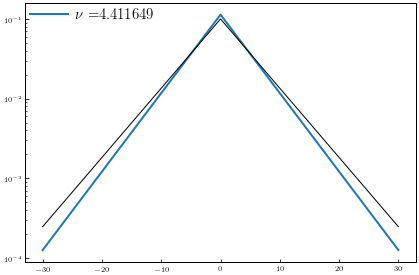

In [10]:
distrName = 'laplace'
x = np.arange(-30, 30, .01)
distr = getattr(stats.distributions, distrName)
param = distr.fit(yawerrs)
print(param)
pdf = distr.pdf(x, *param)
plt.plot(x, pdf, lw=2, label=r'$\nu$ =%f' % param[1])
plt.yscale('log')
#plt.plot(x, distr.pdf(x, 9.579974794390509e-17, 15), c='g')
plt.plot(x, distr.pdf(x, 9.579974794390509e-17, 5), c='k')
#plt.plot(x, distr.pdf(x, 9.579974794390509e-17, 0.2), c='r')
plt.legend(loc='upper left', prop={'size':15})
plt.savefig('hey')

/Users/jquick/myenv/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/jquick/myenv/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


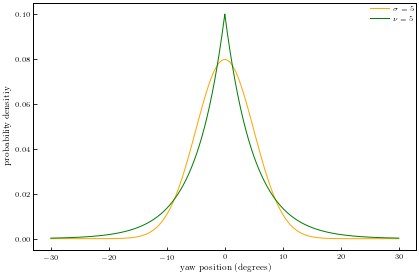

In [11]:
x = np.arange(-30, 30, .01)
plt.plot(x, stats.norm.pdf(x, 0, 5), label=r'$\sigma=5$', c='orange')
plt.plot(x, stats.laplace.pdf(x, 0, 5), label=r'$\nu=5$', c='green')
#plt.plot(x, stats.norm.pdf(x, 0, 2), label=r'$\sigma=2$', c='orange', ls='--')
#plt.plot(x, stats.laplace.pdf(x, 0, 2), label=r'$\nu=2$', c='green', ls='--')
plt.legend()
plt.xlabel('yaw position (degrees)')
plt.ylabel('probability densitiy')
#plt.yscale('log')
plt.savefig('/Users/jquick/Downloads/diffff')


In [12]:
distribution = cp.J(
 cp.Normal(0., 1),
 cp.Normal(0., 1))

#samples = distribution.sample(10, rule='C')
samples = cp.generate_samples(10, domain=[[-60, -60], [60, 60]], rule='C')
plt.scatter(samples[0, :], samples[1, :], s=40)
np.deg2rad(samples[1, :])

NameError: name 'cp' is not defined

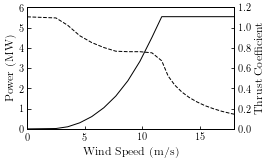

In [57]:
fig, ax0 = plt.subplots(figsize=(4, 2.5))
floris = Floris("example_input.json")  
s = floris.farm.turbines[0].power_thrust_table 
ax0.plot(s['wind_speed'], s['power'] * np.array(s['wind_speed']) ** 3 * floris.farm.air_density * np.pi * floris.farm.turbines[0].rotor_diameter ** 2 / 8 / 1e6, c='k')    
ax2 = ax0.twinx()
ax2.plot(s['wind_speed'], s['thrust'], ls='--', c='k')
ax0.set_xlabel('Wind Speed (m/s)', size=SIZE)
ax0.set_ylabel('Power (MW)', size=SIZE)
ax0.set_xlim(0, 18)
ax0.set_ylim(0, 6)
ax2.set_ylim(0, 1.2)
ax2.set_ylabel('Thrust Coefficient', size=SIZE)

plt.savefig('powerCurve', dpi=600)

In [41]:
s['thrust']

[1.10610965,
 1.09515807,
 1.0227122,
 0.9196487,
 0.8519047,
 0.80328229,
 0.76675469,
 0.76209299,
 0.76209299,
 0.75083241,
 0.67210674,
 0.52188504,
 0.43178758,
 0.36443258,
 0.31049874,
 0.26696686,
 0.22986909,
 0.19961578,
 0.17286245,
 0.15081457,
 0.13146666,
 0.11475968,
 0.10129584,
 0.0880188,
 0.07746819,
 0.06878621,
 0.05977061,
 0.0]

In [1]:
dfTemp['turbinePos'] = dfTemp.Yaw_Encoder_mean + (df.WD_Nacelle_mean - 180.)
fig, ax = plt.subplots()
unclearnerrs = dfTemp.WD1_87m_mean-dfTemp.turbinePos
yawerrs = dfTemp.apparantVane_mean
#yawerrs -= np.mean(yawerrs)
ax.hist(yawerrs, bins=300, normed=1, label='data')
x = np.arange(-30, 30, .01)
SIZE = 16

distrNameList = ['cauchy', 't', 'laplace', 'beta', 'norm']
for distrName in distrNameList:
    distr = getattr(stats.distributions, distrName)
    param = distr.fit(yawerrs)
    pdf = distr.pdf(x, *param)
    ax.plot(x, pdf, lw=3, label=distrName)

ax.set_xlim([-30,30])
ax.axvline(yawerrs.mean(), lw=2, c='k')
ax.set_xlabel("Yaw Position Error" r" ($\degree$)", size=SIZE)
ax.set_ylabel("Probability", size=SIZE)
plt.legend()
print (np.std(yawerrs))

NameError: name 'dfTemp' is not defined

In [19]:
stats.norm.fit(dfTemp.apparantVane_mean)

(3.5756671448147763, 9.354553594696222)

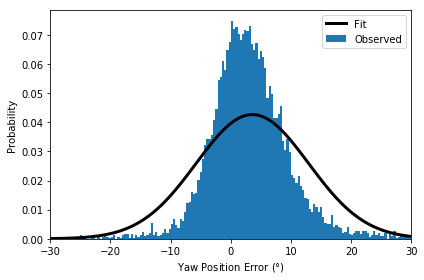

In [23]:
fig, ax = plt.subplots()
ax.hist(dfTemp.apparantVane_mean , bins=500, normed=True, label="Observed")
ax.set_xlim([-30,30])
#ax.axvline(2)
import numpy
x = np.arange(-30, 30, .1)
ax.plot(x, stats.norm.pdf(x, *stats.norm.fit(dfTemp.apparantVane_mean)), lw=3, c='k', label="Fit")
ax.legend()
ax.set_xlabel("Yaw Position Error" r" ($\degree$)")
ax.set_ylabel("Probability")
plt.savefig("YawObsNREL.pdf")

In [29]:
import chaospy as cp
distribution = cp.J(
 cp.student_t(1., 0., 4.37),
 cp.student_t(1., 0., 4.37))


TypeError: __init__() takes from 1 to 2 positional arguments but 4 were given

In [11]:
dir(cp)

['Acf',
 'Ali_mikhail_haq',
 'Alpha',
 'Anglit',
 'Arccos',
 'Arccosh',
 'Archimedean',
 'Arcsin',
 'Arcsinh',
 'Arcsinus',
 'Arctan',
 'Arctanh',
 'Beta',
 'Bradford',
 'Burr',
 'Cauchy',
 'Chi',
 'Chisquard',
 'Clayton',
 'Copula',
 'Corr',
 'Cos',
 'Cosh',
 'Cov',
 'DATATYPES',
 'Dbl_gamma',
 'Dbl_weibull',
 'Dist',
 'E',
 'E_cond',
 'Exponential',
 'Exponpow',
 'Exponweibull',
 'F',
 'Fatiguelife',
 'Fisk',
 'Foldcauchy',
 'Foldnormal',
 'Frank',
 'Frechet',
 'Gamma',
 'Genexpon',
 'Genextreme',
 'Gengamma',
 'Genhalflogistic',
 'Gilbrat',
 'Gompertz',
 'Graph',
 'Gumbel',
 'Hypgeosec',
 'Iid',
 'J',
 'Joe',
 'Joint',
 'Kumaraswamy',
 'Kurt',
 'Laplace',
 'Levy',
 'Loggamma',
 'Logistic',
 'Loglaplace',
 'Lognormal',
 'Loguniform',
 'Logweibul',
 'Maxwell',
 'Mielke',
 'MvLognormal',
 'MvNormal',
 'MvStudent_t',
 'Nakagami',
 'Nataf',
 'Normal',
 'OTDistribution',
 'Pareto1',
 'Pareto2',
 'Perc',
 'Poly',
 'Powerlaw',
 'Powerlognormal',
 'Powernorm',
 'QUAD_FUNCTIONS',
 'QUAD_SHORT